# Notebook to compute power spectrum from the halo distribution

## Loading packages

In [39]:
import numpy as np
import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 16).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
%matplotlib widget


In [3]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(3, list)
class_data = nested_dict(3, list)


## Loading the halos data

In [12]:
directory_halo = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/Halos_snapshots_Box/"

files=["gevolution_boxsize_4032_ngrid_4608_lcdm_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_1_05062020",
       "gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020",
       "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em4_05062020",
        "kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020"];

# redshifts = ["3", "2", "1", "0.5", "0"];
redshifts = ["0"];

files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];



redshift_range=1
for j in range(5): # file
    for i in range(redshift_range): # redshift
#         data['halo'][files_list[j]]['z='+str(redshifts[i])]=np.loadtxt(directory_halo+files[j]+"/output/halos_snapshot/out_"+str(i)+".list");
        data['halo'][files_list[j]]['z='+str(redshifts[i])]=np.loadtxt(directory_halo+files[j]+"/output/halos_snapshot/out_"+str(4)+".list");

#############    
### CLASS ###
#############
directory_class = "/Users/farbod/Dropbox/Projects/Doppler_RSD/Data/CLASS_powers/"
files_list_class = ['lcdm','cs2_1','cs2_e4','cs2_e7'];
redshifts_class = [100, 50, 30, 10, 4, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0];
# CLASS data loading:
for j in range(4):
    
    class_data['bg'][files_list_class[j]]=np.loadtxt(directory_class+files_list_class[j]+"/background.dat");
    for i in range(np.shape(redshifts_class)[0]): # redshift
        class_data['power_cb_lin'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb.dat");
        class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_pk_cb_nl.dat");
        class_data['tk'][files_list_class[j]]['z='+str(redshifts_class[i])]=np.loadtxt(directory_class+files_list_class[j]+"/z"+str(i+1)+"_tk.dat")

# CLASS conversion :
k_pivot = 0.05
A_s = 2.1e-9
n_s = 0.96
h = 0.67
k_class = class_data['tk'][files_list_class[0]]["z=0"][:,0]
conversion = A_s*(k_class*h/k_pivot)**(n_s-1)*(2.*np.pi**2/(k_class**3));


# Header

In [33]:
f = open(directory_halo+files[0]+"/output/halos_snapshot/out_"+str(0)+".list")
header = f.readline()
header_list = header.split(' ') #list of columns
print(header_list)
# print(header_list.index("Mvir"))

['#ID', 'DescID', 'Mvir', 'Vmax', 'Vrms', 'Rvir', 'Rs', 'Np', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'Spin', 'rs_klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Halfmass_Radius\n']


# Halos mass function

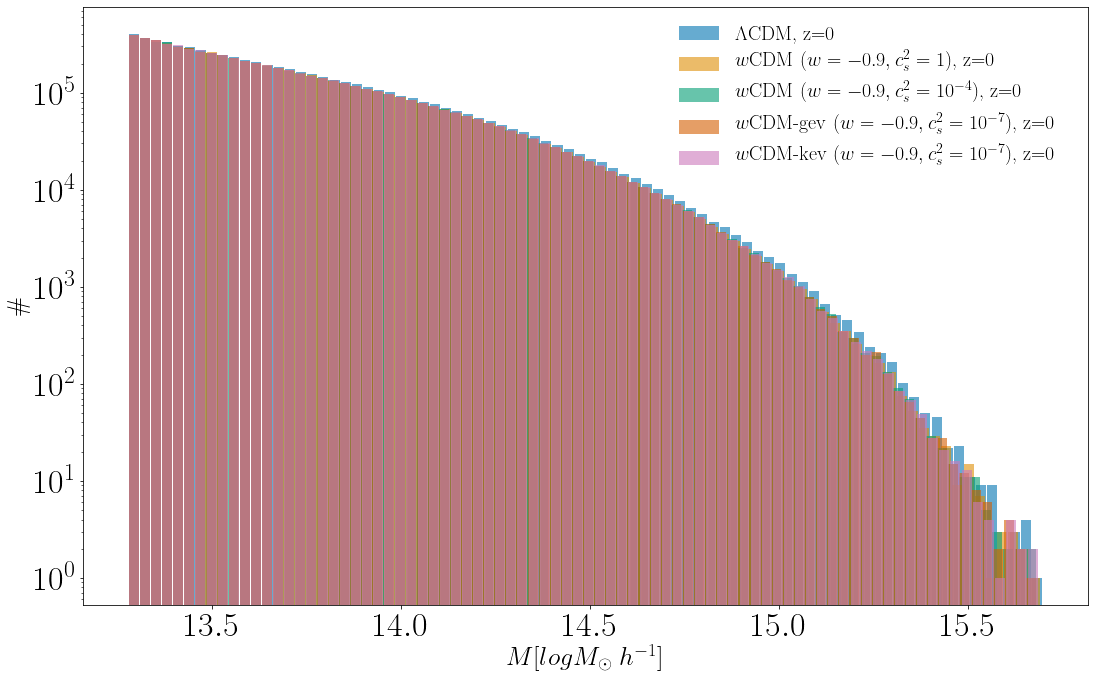

In [190]:
%matplotlib inline
import matplotlib as mpl
label_size = 34
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 11)
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)

redshifts = ["0"];
files_list = ['gev_lcdm','gev_em0','gev_em7','kev_em4','kev_em7'];
decrip = ["$\Lambda$CDM, ","$w$CDM ($w=-0.9, c_s^2=1$), ", "$w$CDM ($w=-0.9, c_s^2=10^{-4}$), ",
          "$w$CDM-gev ($w=-0.9, c_s^2=10^{-7}$), ",
          "$w$CDM-kev ($w=-0.9, c_s^2=10^{-7}$), "]
l=0
for i in [0,1,2,3,4]: # file
# for i in [0]: # file
    for j in [0]: # Redshifts
        redshift ="z="+str(j);

        x=data['halo'][files_list[i]][redshift][:,2];
        plt.hist(np.log10(x), density=False,bins=82, rwidth=0.9,alpha=0.6,color=Colors[l], label=decrip[i]+redshift,histtype='bar')  # density=False would make counts
#         plt.title('Halo mass function')
        plt.ylabel('\#')
        plt.xlabel(r'$M[log M_{\odot} \; h^{-1}$]')
        plt.yscale('log')
        plt.legend(fontsize=20,bbox_to_anchor=[0.78,0.85],loc="center",frameon=False)

        l=l+1
        

plt.show()


# Tinker Halo mass function

In [235]:
import numpy as np
import mass_function_library as MFL

# halo mass function parameters
j=0;i=0;
Pk =  class_data['power_cb_lin'][files_list_class[j]]['z=0'][20:,1]  #file with linear Pk
k =  class_data['power_cb_lin'][files_list_class[j]]['z=0'][20:,0]  #file with linear Pk
# Pk=k**3/(2.*np.pi**2)*Pk
OmegaM = 0.319
Masses = np.logspace(10, 15.5, 100) #array with halo masses
author = 'Tinker'   #Sheth-Tormen halo mass function
bins   = 200  #number of bins to use for Pk
z      = 0.0    #redshift; only used for Tinker, Tinker10 and Crocce
delta  = 200.0  #overdensity; only for Tinker and Tinker10

# read linear matter Pk

# compute halo mass function
HMF = MFL.MF_theory(k, Pk, OmegaM, Masses, author, bins, z, delta)

Delta= 200.0
A= 0.186
a= 1.47
b= 2.57
c= 1.19


In [236]:
HMF

array([2.49146326e-11, 1.95648952e-11, 1.53592677e-11, 1.20535263e-11,
       9.45876151e-12, 7.42508541e-12, 5.83148247e-12, 4.58117775e-12,
       3.59869678e-12, 2.82644188e-12, 2.22003205e-12, 1.74429572e-12,
       1.37089031e-12, 1.07744196e-12, 8.46768904e-13, 6.65572602e-13,
       5.23267512e-13, 4.11429994e-13, 3.23515923e-13, 2.54424444e-13,
       2.00104516e-13, 1.57383070e-13, 1.23797894e-13, 9.73929936e-14,
       7.66236764e-14, 6.02854793e-14, 4.74324497e-14, 3.73221617e-14,
       2.93698607e-14, 2.31136728e-14, 1.81897654e-14, 1.43146590e-14,
       1.12645595e-14, 8.86469594e-15, 6.97591854e-15, 5.48931856e-15,
       4.31896584e-15, 3.39764195e-15, 2.67270030e-15, 2.10224353e-15,
       1.65326395e-15, 1.29992815e-15, 1.02185792e-15, 8.03032234e-16,
       6.30904232e-16, 4.95546064e-16, 3.89105155e-16, 3.05397910e-16,
       2.39575961e-16, 1.87845271e-16, 1.47218104e-16, 1.15319667e-16,
       9.02771348e-17, 7.06211660e-17, 5.52013551e-17, 4.31154942e-17,
      

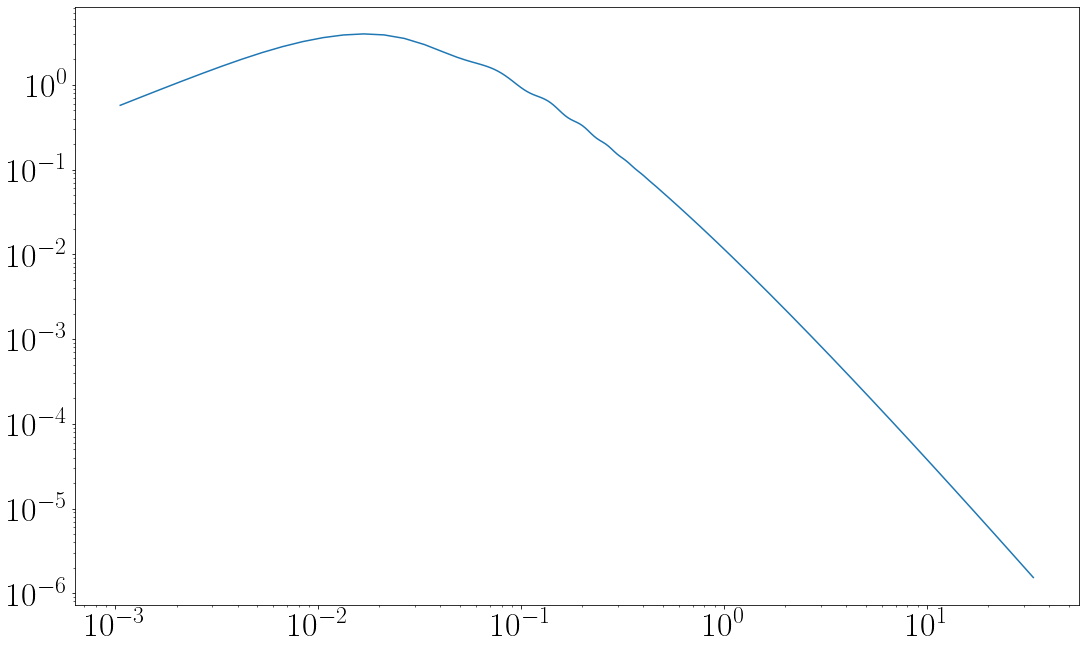

In [227]:
%matplotlib inline
import matplotlib as mpl
label_size = 34
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18, 11)
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : text_size}
matplotlib.rc('font', **font)
Pk =  class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])][20:,1]  #file with linear Pk
k =  class_data['power_cb_nl'][files_list_class[j]]['z='+str(redshifts_class[i])][20:,0]  #file with linear Pk

plt.loglog(k,Pk)
# Pk

In [214]:
np.shape(HMF)

(100,)

In [215]:
HMF

array([ 1.87952210e-040,  3.75614462e-045,  9.52378596e-051,
        3.22859492e-057,  1.95393257e-064,  2.13180569e-072,
        1.91139538e-081,  3.49520504e-092,  4.84468563e-105,
        6.85252351e-120,  2.26357442e-136,  6.94877590e-155,
        8.65030857e-177,  5.70985522e-203,  9.01795275e-233,
        6.34114335e-266,  1.01404506e-304,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,